# Giliojo mokymo sistemų taikymai INF4039
**Individualus  darbas**
#
**Gytis Kalvis**

Duomenų failo aprašymas:
----
"WISDM" rinkinį sudaro duomenys, surinkti iš 51 asmens, kurių kiekvieno buvo prašoma atlikti 18 užduočių po 3 minutes. Kiekvienas tiriamasis kišenėje turėjo išmanųjį telefoną. Duomenų rinkimas buvo valdomas specialiai sukurta programėle, kuri veikė išmaniajame telefone ir išmaniajame laikrodyje. Tyrimo metu buvo matuojamas telefono jutikliais surinkti x, y ir z ašies duomenys.

Eilučių skaičius: 1,098,207  
Atributų skaičius: 6  
Klasės pasiskirstymas: {  
-	Walking -> 424 400 -> 38,6 %,  
-	Jogging -> 342 177 -> 31,2 %,  
-	Upstairs -> 122 869 -> 11,2 %,  
-	Downstairs -> 100 427 -> 9,1 %,  
-	Sitting -> 59 939 -> 5,5 %, 
-	Standing -> 48 395 -> 4,4 % }  

formatas:  
[tiriamasis],[veikla],[laikas],[x pagreitis],[y pagreitis],[z pagreitis];  

Duomenų dažnis:   
20 Hz (kas 50 ms)  

Laukai:  
*vartotojas  
-	1..36  

*veikla
-   Walking  
-	Jogging  
-	Upstairs  
-	Downstairs  
-	Sitting  
-	Standing  

*laikas  
-	skaitinis, paprastai telefono veikimo laikas nanosekundėmis  

*x-akceleracija  
-	skaitinis, slankiojo kablelio reikšmės nuo -20 ... 20  
-	Išmatuotas pagreitis x kryptimi išmatuotas "Android" telefono akselerometru. Reikšmė 10 = 1g = 9,81 m/s^2, o 0 = pagreičio nėra. Į užregistruotą pagreitį įeina gravitacinis pagreitį į Žemės centrą, todėl kai telefonas yra ramybės būsenoje ant lygaus paviršiaus vertikalioji ašis fiksuos +-10.  

*y-accel  
-	taip pat kaip x-akceleracija  

*z pagreitis  
-   taip pat kaip x-akceleracija  

Hipotezė
---
- Tikimasi, kad CNN, gebantys fiksuoti erdvinius ryšius, bus pranašesni nustatant dėsningumus atskiruose duomenų laiko rėmuose. LSTM turėtų taip pat būti tikslus, tačiau ne toks greitas, kaip CNN. Random Forest tūrėtų būti greitesnis nei CNN ir LSTM, kadangi nenaudoja neuroninių tinklų.

Tikslas
----
- Ištirti ir palyginti CNN, LSTM ir Random Forest modelių tikslumą bei greitį klasifikuojant žmogaus veiklą pagal akselerometro duomenis.

Uždaviniai
---
1. Atlikti tiriamąją duomenų analizę ir apdoroti duomenis klasifikavimui, įskaitant normalizavimą ir segmentavimą.
2. Aprašyti konvoliucinį neuroninį tinklą (CNN) ir atrasti geriausius jo parametrus, duodančius didžiausią tikslumą.
3. Aprašyti ilgosios trumpalaikės atminties (LSTM) tinklą ir atrasti geriausius jo parametrus, duodančius didžiausią tikslumą.
4. Aprašyti Random Forest klasifikatorių ir atrasti geriausius jo parametrus, duodančius didžiausią tikslumą.

Importojamos bibliotekos

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Duomenų importavimas:

In [42]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
df = pd.read_csv("Wisdom_ar_all_column.csv", names = columns, on_bad_lines = 'warn', skiprows=1, skipfooter=1, engine='python')

Pašalinamos z reikšmės, kurių neina konvertuoti į skaičių:

In [43]:
df = df[pd.to_numeric(df['z'], errors='coerce').notnull()]
df['z'] = df['z'].astype(float)

In [44]:
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [45]:
df.tail()

,user,activity,time,x,y,z
1098203,19,Sitting,131623291475000,9.00,-1.50,1.80
1098204,19,Sitting,131623331483000,9.00,-1.57,1.69
1098205,19,Sitting,131623371431000,9.04,-1.46,1.73
1098206,19,Sitting,131623411592000,9.08,-1.38,1.69
1098207,19,Sitting,131623491487000,9.00,-1.46,1.73


In [46]:
df.shape

(1098207, 6)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098207 entries, 0 to 1098207
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   user      1098207 non-null  int64  
 1   activity  1098207 non-null  object 
 2   time      1098207 non-null  int64  
 3   x         1098207 non-null  float64
 4   y         1098207 non-null  float64
 5   z         1098207 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [48]:
df.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

Duomenų rinkinys neturi tuščių laukelių.

In [49]:
countOfActivity = df['activity'].value_counts()
print(countOfActivity)

activity
Walking       424399
Jogging       342179
Upstairs      122869
Downstairs    100427
Sitting        59938
Standing       48395
Name: count, dtype: int64


<Axes: title={'center': 'Duomenų skaičius pagal veiklos tipą'}, xlabel='activity'>

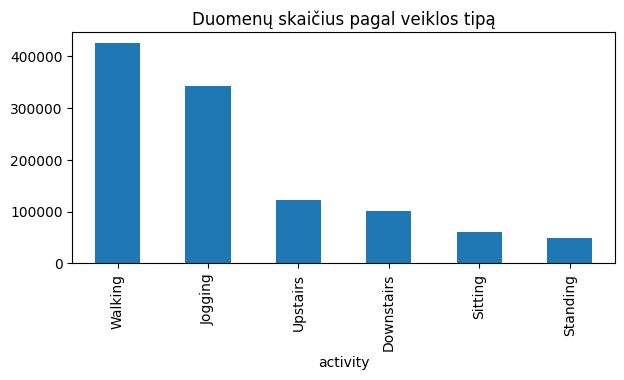

In [50]:
countOfActivity.plot(kind = 'bar', title = 'Duomenų skaičius pagal veiklos tipą', figsize = (7,3))

<Axes: title={'center': 'Duomenų skaičius pagal žmogų'}, xlabel='user'>

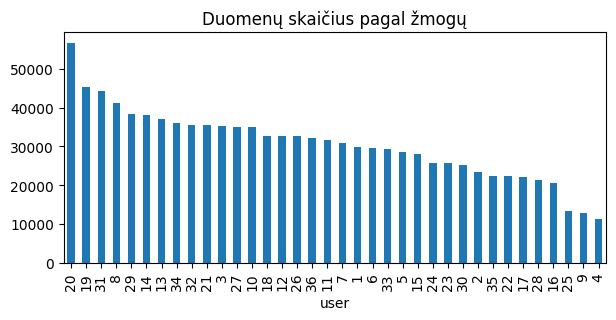

In [51]:
df['user'].value_counts().plot(kind='bar', title='Duomenų skaičius pagal žmogų', figsize = (7,3))

Išskiriami veiklų tipai:

In [52]:
activities = df['activity'].value_counts().index

Aprašoma funkcija, skirta pavaizduoti duomenų failą:

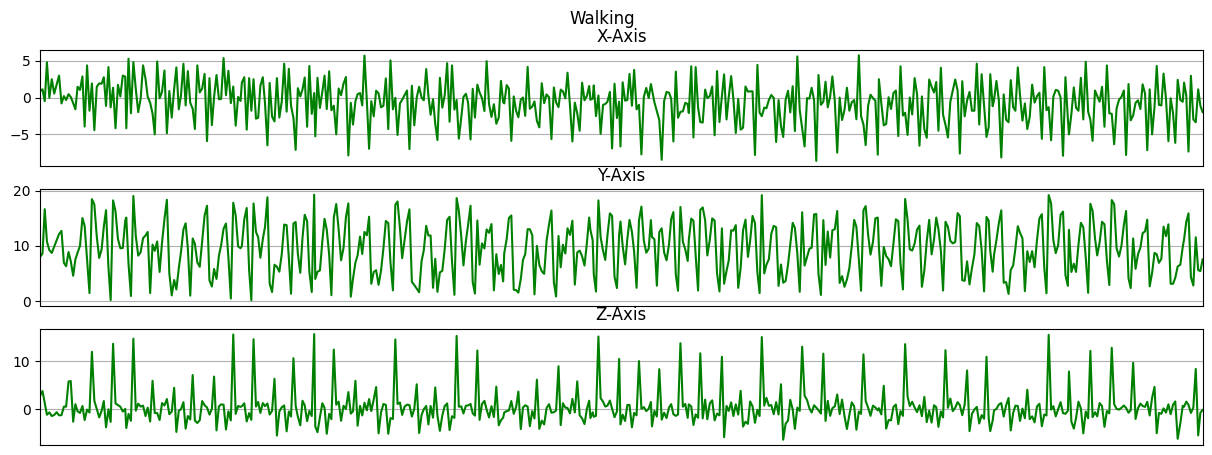

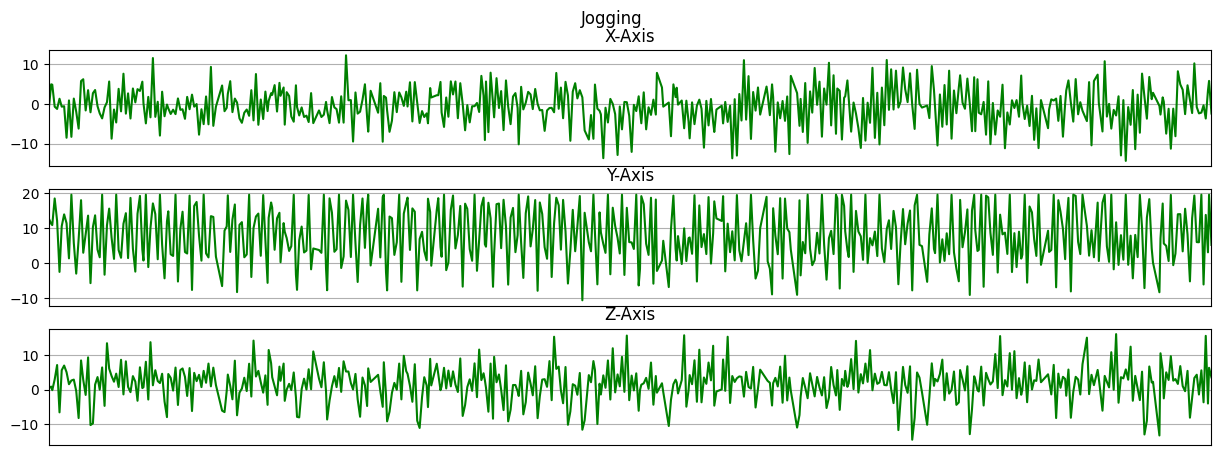

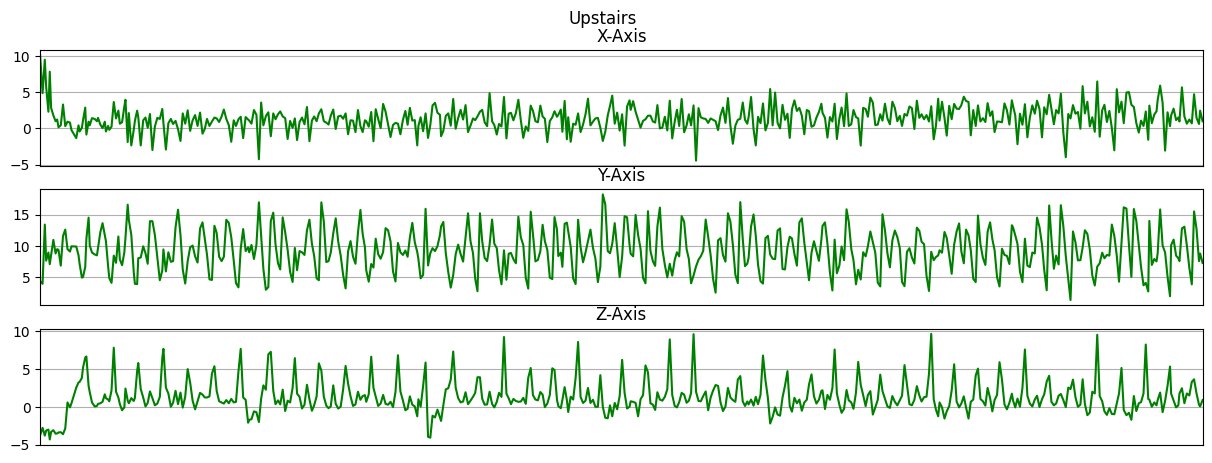

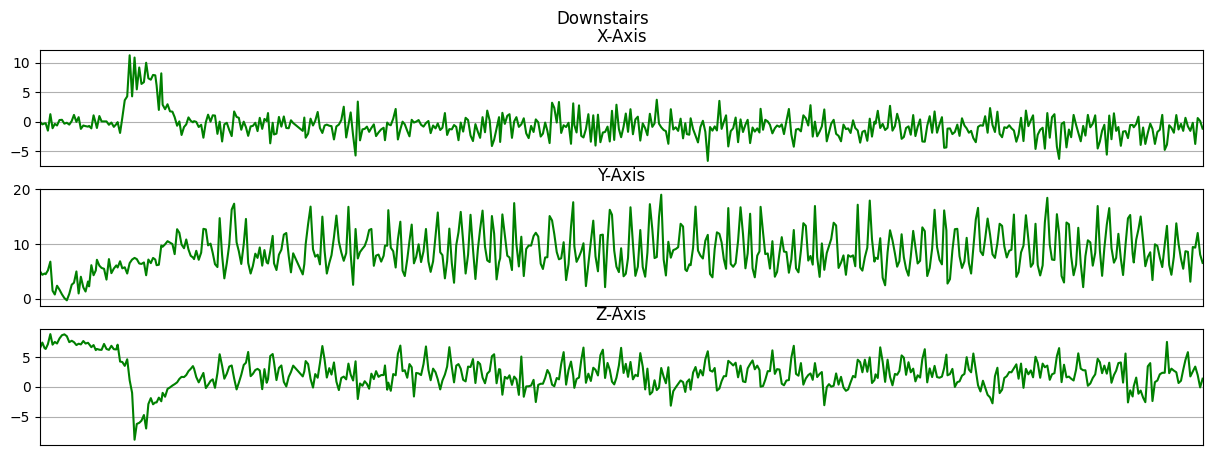

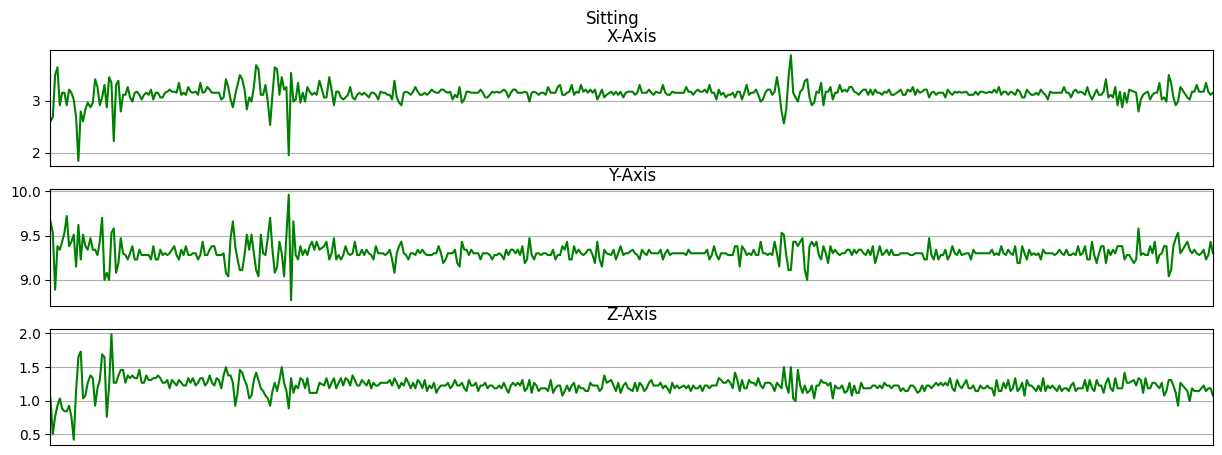

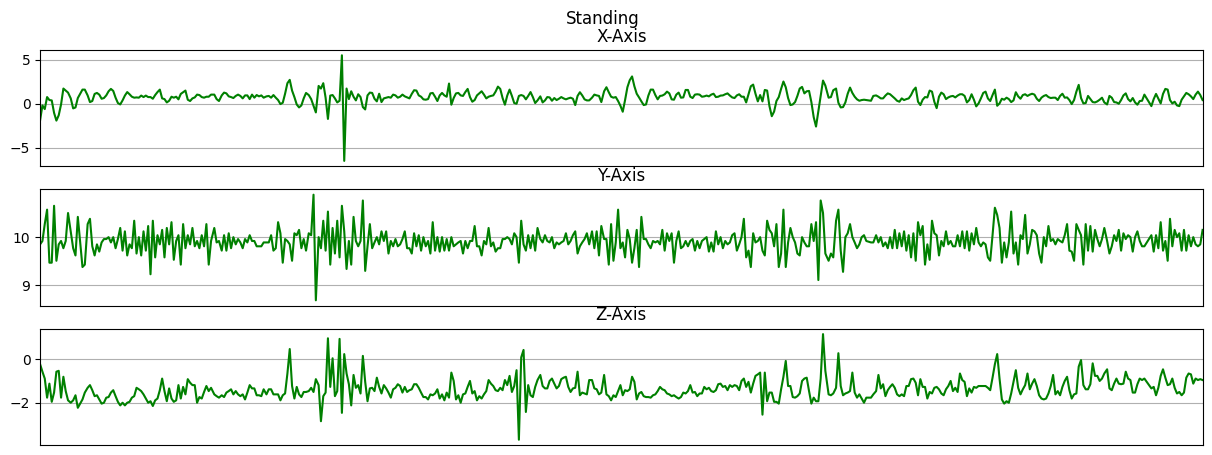

In [53]:
def plot_activity(activity,data):
  fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,5), sharex=True)
  plot_axis(ax0, data['time'],data['x'], 'X-Axis')
  plot_axis(ax1, data['time'],data['y'], 'Y-Axis')
  plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
  plt.subplots_adjust(hspace=0.2)
  fig.suptitle(activity)
  plt.subplots_adjust(top=0.90)
  plt.show()

def plot_axis(ax,x,y,title):
  ax.plot(x, y, 'g')
  ax.set_title(title)
  ax.xaxis.set_visible(False)
  ax.set_xlim([min(x), max(x)])
  ax.grid(True)

for activity in activities:
  data_for_plot = df[(df['activity'] == activity)].head(500)
  plot_activity(activity, data_for_plot)

In [54]:
def plot_corr(activity, df):
    activity_df = df[df["activity"]==activity]
    numeric_columns = activity_df.select_dtypes(include=[np.number]).columns
    corr = activity_df[numeric_columns].corr()
    corr = corr[["x","y","z"]][2:5]
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=100)    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

Vaikštant y ir x ašys yra neigiamai koreliuotos, y ir z ašys yra teigiamai koreliuotos, o z ir x ašys nėra koreliuotos:

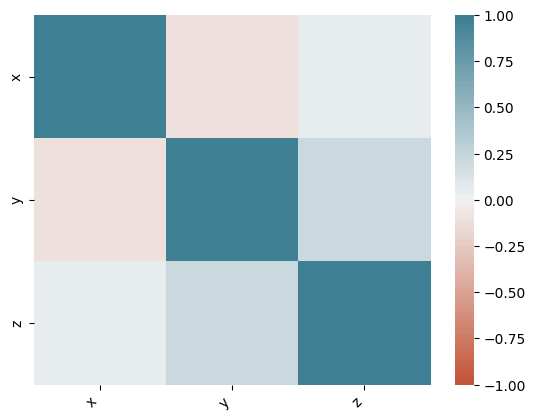

In [55]:
plot_corr("Walking",df)

Bėgant z ir y ašys nėra koreliuotos, x ir y bei x ir z ašys tarpusavyje koreliuoja teigiamai:

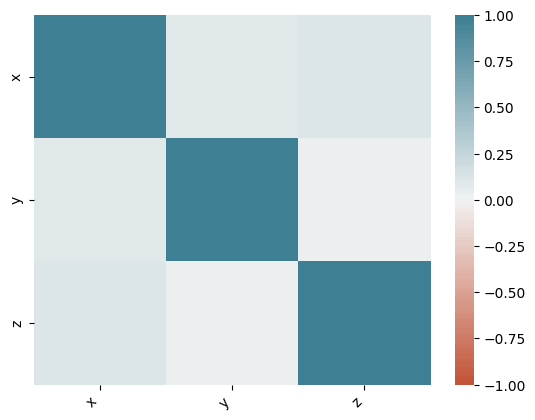

In [56]:
plot_corr("Jogging",df)

CNN
-----

Pašalinami nereikalingi stulpeliai apmokymui ir rezultatas kopijuojamas į df1

In [57]:
df1 = df.drop(['user','time'], axis = 1).copy()
df1.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [58]:
df1['activity'].value_counts()

activity
Walking       424399
Jogging       342179
Upstairs      122869
Downstairs    100427
Sitting        59938
Standing       48395
Name: count, dtype: int64

Duomenų failas padalinamas į atskiras, vienodo dydžio, veiklas:

In [59]:
Walking = df1[df1['activity']=='Walking'].head(48395).copy()
Jogging = df1[df1['activity']=='Jogging'].head(48395).copy()
Upstairs = df1[df1['activity']=='Upstairs'].head(48395).copy()
Downstairs = df1[df1['activity']=='Downstairs'].head(48395).copy()
Sitting = df1[df1['activity']=='Sitting'].head(48395).copy()
Standing = df1[df1['activity']=='Standing'].head(48395).copy()

Gautas vienodo dydžio veiklų duomenys vėl sujungiami į vieną duomenų rinkinį:

In [60]:
balanced_data = pd.DataFrame()
balanced_data = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing], ignore_index=True)
balanced_data.shape

(290370, 4)

In [61]:
balanced_data['activity'].value_counts()

activity
Walking       48395
Jogging       48395
Upstairs      48395
Downstairs    48395
Sitting       48395
Standing      48395
Name: count, dtype: int64

In [62]:
balanced_data.head()

,activity,x,y,z
0,Walking,0.844462,8.008764,2.792171
1,Walking,1.116869,8.621680,3.786457
2,Walking,-0.503953,16.657684,1.307553
3,Walking,4.794363,10.760075,-1.184970
4,Walking,-0.040861,9.234595,-0.694638


Veiklų pavadinimai transformuojami į skaičius:

In [63]:
le = LabelEncoder()
balanced_data['activity'] = le.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z
0,5,0.844462,8.008764,2.792171
1,5,1.116869,8.621680,3.786457
2,5,-0.503953,16.657684,1.307553
3,5,4.794363,10.760075,-1.184970
4,5,-0.040861,9.234595,-0.694638


Aprašomi požymių ir tikslo duomenys:

In [64]:
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['activity']

Standartizuojamos požymių reikšmės:

In [65]:
scaler  = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x','y','z'])
scaled_X['activity'] = y.values

In [66]:
scaled_X

,x,y,z,activity
0,-0.034494,0.076973,0.266483,5
1,0.017280,0.187552,0.495747,5
2,-0.290774,1.637366,-0.075841,5
3,0.716224,0.573350,-0.650570,5
4,-0.202759,0.298131,-0.537509,5
...,...,...,...,...
290365,-1.143392,0.145754,-0.464959,3
290366,-1.170001,0.118691,-0.474182,3
290367,-1.061666,0.165599,-0.582556,3
290368,-1.046462,0.172816,-0.626366,3


In [67]:
NUM_EPOCHS = 50
Fs = 20
frame_size = Fs*4
hop_size = Fs*2

In [68]:
def get_frames(df, frame_size, hop_size):
  N_FEATURES = 3

  frames = []
  labels  = []
  for i in range(0, len(df) - frame_size, hop_size):
    x = df['x'].values[i: i + frame_size]
    y = df['y'].values[i: i + frame_size]
    z = df['z'].values[i: i + frame_size]
    activities = df['activity'][i: i + frame_size]
    unique_activities, counts = np.unique(activities, return_counts=True)
    label = unique_activities[np.argmax(counts)]
    frames.append([x,y,z])
    labels.append(label)

  return np.asarray(frames).reshape(-1, frame_size , N_FEATURES), np.asarray(labels)

In [69]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [70]:
np.shape(X)

(7258, 80, 3)

In [71]:
np.shape(y)

(7258,)

Duomenys padalijami į mokymo ir testavimo rinkinius naudojant KFold Cross-validation:

In [72]:
# num_folds = 5
# kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1337)

In [73]:
# fold_no = 1
# for train, test in kfold.split(X, y):
#     model = Sequential()
#     model.add(BatchNormalization(input_shape=(80, 3, 1)))
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(6, activation='sigmoid'))
    
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     print(f'Training for fold {fold_no} ...')

#     history = model.fit(X[train], y[train],
#                         epochs=NUM_EPOCHS,
#                         validation_data=(X[test], y[test]),
#                         verbose=1)

#     fold_no = fold_no + 1

Duomenys padalijami į mokymo ir testavimo rinkinius naudojant train_test_split:

In [74]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=111, stratify = y)

num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [83]:
y_train

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [75]:
x_train.shape , x_test.shape

((5806, 80, 3), (1452, 80, 3))

In [76]:
x_train[0].shape, x_test[0].shape

((80, 3), (80, 3))

In [77]:
x_train = x_train.reshape(5806,80,3,1)
x_test = x_test.reshape(1452,80,3,1)

In [78]:
x_train[0].shape, x_test[0].shape

((80, 3, 1), (80, 3, 1))

In [79]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [80]:
# model = Sequential()
# model.add(Conv2D(16,(2,2), activation = 'relu', input_shape = x_train[0].shape))
# model.add(Dropout(0.1))

# model.add(Conv2D(32,(2,2), activation='relu'))
# model.add(Dropout(0.2))

# model.add(Flatten())

# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(6, activation='softmax'))
# model.summary()

val_loss: 0.1827 - val_accuracy: 0.9525  

In [81]:
model = Sequential()

model.add(BatchNormalization(input_shape=x_train[0].shape))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 80, 3, 1)          4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 80, 3, 32)         320       
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 3, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 3, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 256)               1966336   
                                                        

dropout 0.2     val_loss: 0.1910 - val_accuracy: 0.9738  
dropout 0.5     val_loss: 0.3771 - val_accuracy: 0.9511  \
training accuracy 0.99

In [85]:
model.compile(optimizer='SGD',loss= 'categorical_crossentropy', metrics=['accuracy'])
history=model.fit(x_train,y_train, epochs = NUM_EPOCHS, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
182/182 [==============================] - 1s 7ms/step - loss: 1.3604 - accuracy: 0.5086 - val_loss: 0.8588 - val_accuracy: 0.6481
Epoch 2/50
182/182 [==============================] - 1s 7ms/step - loss: 0.7279 - accuracy: 0.6976 - val_loss: 0.5941 - val_accuracy: 0.7328
Epoch 3/50
182/182 [==============================] - 1s 7ms/step - loss: 0.6026 - accuracy: 0.7401 - val_loss: 0.5613 - val_accuracy: 0.7404
Epoch 4/50
182/182 [==============================] - 1s 7ms/step - loss: 0.5439 - accuracy: 0.7677 - val_loss: 0.4804 - val_accuracy: 0.7893
Epoch 5/50
182/182 [==============================] - 1s 7ms/step - loss: 0.4803 - accuracy: 0.7954 - val_loss: 0.5400 - val_accuracy: 0.7583
Epoch 6/50
182/182 [==============================] - 1s 7ms/step - loss: 0.4412 - accuracy: 0.8209 - val_loss: 0.4452 - val_accuracy: 0.8030
Epoch 7/50
182/182 [==============================] - 1s 7ms/step - loss: 0.4050 - accuracy: 0.8391 - val_loss: 0.3972 - val_accuracy: 0.8492
Epoch 

optimizer Adam  ----> val_loss: 0.2839 - val_accuracy: 0.9669  
optimizer Nadam ----> val_loss: 0.4530 - val_accuracy: 0.9483  
optimizer SGD   ----> val_loss: 0.1490 - val_accuracy: 0.9649

In [86]:
def plot_learningCurve(history,epochs):

  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Modelio tikslumas')
  plt.ylabel('Tikslumas')
  plt.xlabel('Epocha')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Modelio nuostoliai')
  plt.ylabel('Nuostolis')
  plt.xlabel('Epocha')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()
  

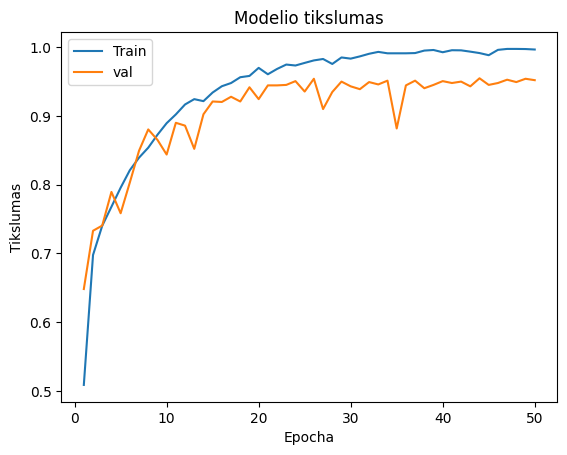

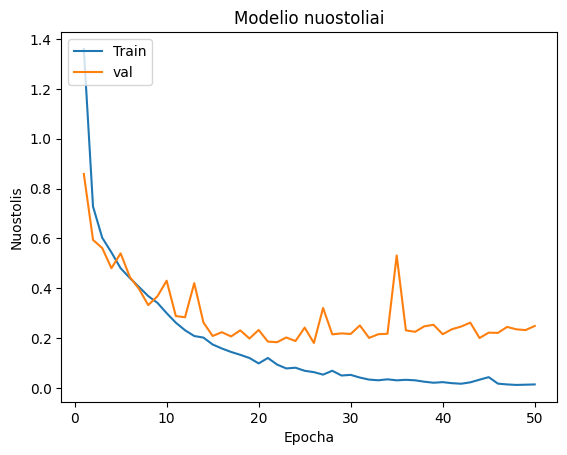

In [87]:
plot_learningCurve(history,50)

LSTM
----

In [154]:
df2 = df.copy()
df2.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [155]:
N_FEATURES = 3
TIME_STEPS = 100 # 5 sekundes
STEP = 50 # puse TIME_STEPS
BATCH_SIZE = 64
NUM_EPOCHS = 50

Duomenys padalijami į aukščiau aprašyto laiko intervalus:

In [156]:
def create_segments_and_labels(df, time_steps, step, label_name):
    segments = []
    labels = []
    for i in range(0,len(df) - time_steps, step):
        xs = df['x'].values[i: i + time_steps]
        ys = df['y'].values[i: i + time_steps]
        zs = df['z'].values[i: i + time_steps]
        activities = df['activity'][i: i + time_steps]
        unique_activities, counts = np.unique(activities, return_counts=True)
        label = unique_activities[np.argmax(counts)]
        segments.append([xs,ys,zs])
        labels.append(label)
    return np.asarray(segments).reshape(-1, time_steps, N_FEATURES), np.asarray(labels)

In [157]:
le = LabelEncoder()
df2['activity'] = le.fit_transform(df2['activity'])
segments, labels = create_segments_and_labels(df2, TIME_STEPS, STEP, 'activity')

In [158]:
segments.shape, labels.shape

((21963, 100, 3), (21963,))

In [86]:
# df2[['x', 'y', 'z']] = df2[['x', 'y', 'z']].apply(pd.to_numeric)

x_train, x_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=111, shuffle=False)

num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [87]:
def scale_data(X):
    for i in range(X.shape[2]):  # Einama pro kiekvieną stulpelį (x, y, z)
        scaler  = StandardScaler()
        X[:, :, i] = scaler.fit_transform(X[:, :, i].reshape(-1, 1)).reshape(-1, X.shape[1])
    return X

x_train_scaled = scale_data(x_train)
x_test_scaled = scale_data(x_test)

In [88]:
model = keras.Sequential()

# model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, N_FEATURES)))
# model.add(keras.layers.LSTM(64))
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(TIME_STEPS, N_FEATURES)))
model.add(Dropout(0.3))
model.add(keras.layers.LSTM(50))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          41600     
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 306       
                                                                 
Total params: 72106 (281.66 KB)
Trainable params: 72106 (281.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Modelio apmokymas:

In [89]:
history = model.fit(x_train_scaled, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test_scaled, y_test))

Epoch 1/50
275/275 [==============================] - 25s 88ms/step - loss: 1.0354 - accuracy: 0.6362 - val_loss: 0.7595 - val_accuracy: 0.7344
Epoch 2/50
275/275 [==============================] - 24s 86ms/step - loss: 0.7525 - accuracy: 0.7379 - val_loss: 0.6268 - val_accuracy: 0.7917
Epoch 3/50
275/275 [==============================] - 24s 89ms/step - loss: 0.6492 - accuracy: 0.7738 - val_loss: 0.6101 - val_accuracy: 0.7844
Epoch 4/50
275/275 [==============================] - 24s 87ms/step - loss: 0.5941 - accuracy: 0.7923 - val_loss: 0.5228 - val_accuracy: 0.8149
Epoch 5/50
275/275 [==============================] - 24s 88ms/step - loss: 0.5465 - accuracy: 0.8047 - val_loss: 0.5364 - val_accuracy: 0.8074
Epoch 6/50
275/275 [==============================] - 24s 86ms/step - loss: 0.5204 - accuracy: 0.8147 - val_loss: 0.4600 - val_accuracy: 0.8320
Epoch 7/50
275/275 [==============================] - 24s 86ms/step - loss: 0.4928 - accuracy: 0.8217 - val_loss: 0.5399 - val_accuracy:

Modelio įvertinimas:

138/138 [==============================] - 2s 16ms/step - loss: 0.1524 - accuracy: 0.9565
Tikslumas: 0.95652174949646, Nuostoliai: 0.1524338275194168
138/138 [==============================] - 2s 15ms/step


<Axes: >

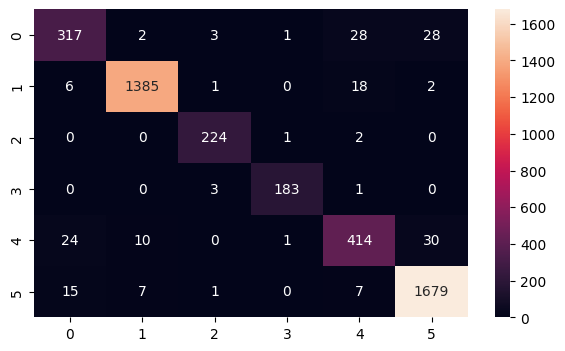

In [90]:
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f"Tikslumas: {accuracy}, Nuostoliai: {loss}")

y_pred = model.predict(x_test_scaled)
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(confusion_matrix, annot=True, fmt="d")

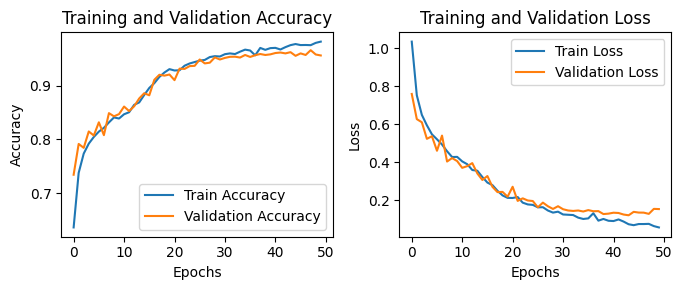

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))

# Tikslumas
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Nuostuoliai
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

LSTM (64) -> LSTM (64) -> Dense (64, ReLU) -> Dropout (0.2) -> Dense (Softmax):  

TIME_STEPS = 128  
STEP = 64  
BATCH_SIZE = 32  
NUM_EPOCHS = 10  
Test Accuracy: 0.825, Test Loss: 0.490  

TIME_STEPS = 128  
STEP = 64  
BATCH_SIZE = 32  
NUM_EPOCHS = 50  
Test Accuracy: 0.932, Test Loss: 0.222

TIME_STEPS = 200  
STEP = 20  
BATCH_SIZE = 128  
NUM_EPOCHS = 10  
Test Accuracy: 0.835, Test Loss: 0.464  

TIME_STEPS = 128  
STEP = 128  
BATCH_SIZE = 32  
NUM_EPOCHS = 10  
Test Accuracy: 0.787, Test Loss: 0.599  

TIME_STEPS = 200  
STEP = 200  
BATCH_SIZE = 10  
NUM_EPOCHS = 10  
Test Accuracy: 0.781, Test Loss: 0.619  

TIME_STEPS = 200  
STEP = 200  
BATCH_SIZE = 10  
NUM_EPOCHS = 50  
Test Accuracy: 0.924, Test Loss: 0.355

TIME_STEPS = 200  
STEP = 200  
BATCH_SIZE = 100  
NUM_EPOCHS = 50  
Test Accuracy: 0.805, Test Loss: 0.563  


LSTM (100) -> Dropout (0.3) -> LSTM (50) -> Dropout (0.3) -> Dense (Softmax):  

TIME_STEPS = 200  
STEP = 100  
BATCH_SIZE = 64  
NUM_EPOCHS = 50  
Test Accuracy: 0.915, Test Loss: 0.238

TIME_STEPS = 100  
STEP = 50  
BATCH_SIZE = 64  
NUM_EPOCHS = 50  
Test Accuracy: 0.964, Test Loss: 0.121

Random Forest
------

In [160]:
df3 = df2.copy()
df3.head()

,user,activity,time,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [93]:
# clf = RandomForestClassifier(n_estimators=100, random_state=111)
# clf.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.48      0.46      0.47      9739
           1       0.78      0.79      0.78      9674
           2       0.99      0.98      0.98      9619
           3       0.89      0.94      0.91      9709
           4       0.44      0.39      0.41      9669
           5       0.52      0.57      0.54      9664

    accuracy                           0.69     58074
    macro avg      0.68      0.69      0.68     58074
    weighted avg   0.68      0.69      0.68     58074


In [161]:
window_size = 200   # 10 sekundziu
stride = 20         # 1 sekunde

Išgaunamos statistinės reikšmės iš duomenų rinkinio segmentų:

In [162]:
def extract_features(data, window_size, stride):
    features = []
    for start in range(0, len(data) - window_size, stride):
        window = data.iloc[start:start + window_size]
        features.append([
            window.mean().mean(),
            window.std().mean(),
            window.min().min(),
            window.max().max()
        ])
    return pd.DataFrame(features)

In [164]:
# Sukuriami požymiai ir tikslai
feature_data = extract_features(df3[['x', 'y', 'z']], window_size, stride)
target_indices = range(0, len(df3) - window_size, stride)
target_data = df3['activity'].iloc[target_indices]

# Patikrinama ar požymių ir tikslų duomenų kiekis sutampa
min_length = min(len(feature_data), len(target_data))
feature_data = feature_data.iloc[:min_length]
target_data = target_data.iloc[:min_length]

In [165]:
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.2, random_state=111)

In [166]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [167]:
rf = RandomForestClassifier(random_state=111)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=111)

In [169]:
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1024
           1       0.97      0.98      0.97      3436
           2       0.99      0.96      0.98       616
           3       0.97      0.96      0.96       492
           4       0.90      0.84      0.87      1258
           5       0.94      0.97      0.96      4155

    accuracy                           0.94     10981
   macro avg       0.94      0.92      0.93     10981
weighted avg       0.94      0.94      0.94     10981



Išvados
----
Random Forest klasifikatorius šiuo tyrimo metu pasiekė 94% tikslumą per 4-5 sekundes. CNN, nors ir lėtesnis, pasiekė ~96% tikslumą. LSTM taip pat pasiekė ~96% tikslumą, tačiau jis buvo gerokai lėtesnis nei Random Forest ir CNN modeliai - apie 15 minučių skaičiuojant 50 epochų. Toks lėtesnis LSTM veikimas rodo skaičiavimo intensyvumą, kurio reikia sudėtingam laikinių duomenų sekų apdorojimui.